In [3]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import hdbscan
import time
import pandas as pd
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import ast
import umap
import plotly.express as px
import plotly.graph_objects as go

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load CSV
df = pd.read_csv('../data/afterllm/ingredients_reduced.csv')

# Parse the string ingredients to list
if isinstance(df['ingredients'].iloc[0], str):
    df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Build the vocabulary
all_ingredients = []
for ing_list in df['ingredients']:
    all_ingredients.extend(set(ing_list))

unique_ingredients = sorted(set(all_ingredients))
ingredients_index = {ing: idx for idx, ing in enumerate(unique_ingredients)}
n_ingredients = len(unique_ingredients)
n_recipes = len(df)

print(f"Total recipes: {n_recipes}")
print(f"Total unique ingredients: {n_ingredients}")

# Build the sparse matrix (recipes x ingredients)
X = lil_matrix((n_recipes, n_ingredients), dtype=bool)

for r, ing_list in enumerate(df['ingredients']):
    for ing in set(ing_list):
        if ing in ingredients_index:
            X[r, ingredients_index[ing]] = True

print(f"Sparse matrix shape: {X.shape}")
print(f"Sparsity: {1 - X.nnz / (X.shape[0]*X.shape[1]):.4f}") 

X = X.tocsr()
X_ingredients = X.T

Total recipes: 222705
Total unique ingredients: 9864
Sparse matrix shape: (222705, 9864)
Sparsity: 0.9991


In [5]:

# ============================================================================
# DIMENSIONALITY REDUCTION (Applied to all methods)
# ============================================================================
print("\n" + "="*80)
print("APPLYING TRUNCATEDSVD DIMENSIONALITY REDUCTION")
print("="*80)

N_COMPONENTS = 100
print(f"Reducing from {n_ingredients} dimensions to {N_COMPONENTS} dimensions...")

svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
X_reduced = normalize(svd.fit_transform(X_ingredients))

print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.3f}")
print(f"Reduced matrix shape: {X_reduced.shape}")


APPLYING TRUNCATEDSVD DIMENSIONALITY REDUCTION
Reducing from 9864 dimensions to 100 dimensions...
Explained variance ratio: 0.574
Reduced matrix shape: (9864, 100)



1. K-Means (Partitioning baseline)
Testing k=20...
  Silhouette: 0.047, Time: 0.0s
Testing k=30...
  Silhouette: 0.055, Time: 0.1s
Testing k=40...
  Silhouette: 0.056, Time: 0.1s
Testing k=50...
  Silhouette: 0.057, Time: 0.1s
Testing k=100...
  Silhouette: 0.060, Time: 0.1s

2. DBSCAN (Density-based)
Testing eps=0.5...
  Clusters: 18, Noise: 94.2%, Silhouette: 0.42448305285587723, Time: 0.2s
Testing eps=0.6...
  Clusters: 26, Noise: 88.3%, Silhouette: 0.23137828631664467, Time: 0.2s
Testing eps=0.65...
  Clusters: 30, Noise: 82.9%, Silhouette: 0.13925215264368893, Time: 0.2s
Testing eps=0.7...
  Clusters: 29, Noise: 75.2%, Silhouette: 0.005845373322979056, Time: 0.2s

3. HDBSCAN (Hierarchical density-based)
Testing min_cluster_size=10...


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Clusters: 41, Noise: 89.2%, Silhouette: 0.3334017899427836, Time: 7.3s
Testing min_cluster_size=15...


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Clusters: 25, Noise: 90.9%, Silhouette: 0.340551047292407, Time: 6.9s
Testing min_cluster_size=20...


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Clusters: 2, Noise: 68.6%, Silhouette: 0.019336681352564243, Time: 7.5s

4. Agglomerative Clustering (Hierarchical)
Testing ward linkage, k=20...
  Silhouette: 0.018, Time: 2.2s
Testing ward linkage, k=30...
  Silhouette: 0.017, Time: 2.2s
Testing ward linkage, k=40...
  Silhouette: 0.017, Time: 2.4s
Testing complete linkage, k=20...
  Silhouette: -0.004, Time: 2.1s
Testing complete linkage, k=30...
  Silhouette: -0.002, Time: 2.1s
Testing complete linkage, k=40...
  Silhouette: -0.000, Time: 2.1s
Testing average linkage, k=20...
  Silhouette: -0.008, Time: 2.3s
Testing average linkage, k=30...
  Silhouette: -0.012, Time: 2.3s
Testing average linkage, k=40...
  Silhouette: -0.007, Time: 2.3s
Testing single linkage, k=20...
  Silhouette: -0.079, Time: 2.1s
Testing single linkage, k=30...
  Silhouette: -0.105, Time: 2.1s
Testing single linkage, k=40...
  Silhouette: -0.108, Time: 2.1s

COMPREHENSIVE RESULTS SUMMARY
       Method       Variant  N_Clusters  Noise_Pct  Silhouette  Davies_

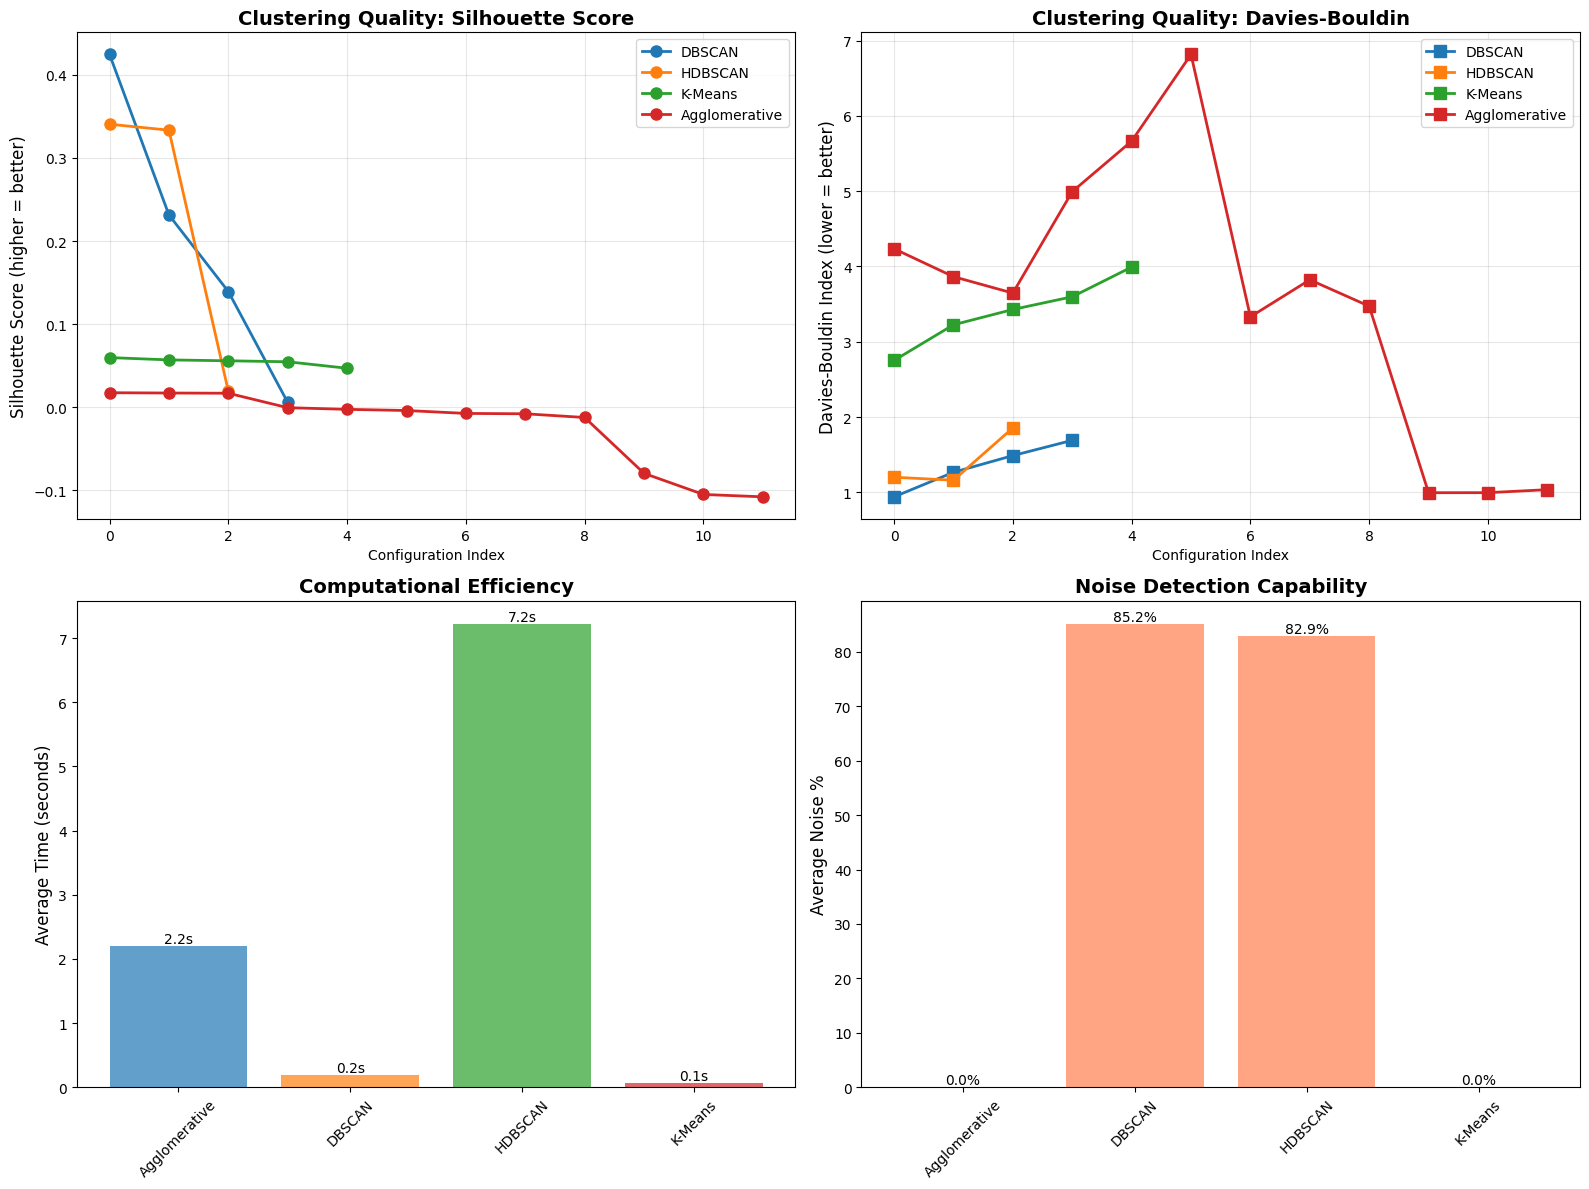

In [7]:
# ============================================================================
# COMPREHENSIVE CLUSTERING COMPARISON
# ============================================================================

def comprehensive_clustering_comparison():
    """
    Compare ALL clustering methods systematically with TruncatedSVD applied
    """
    
    methods_to_compare = []
    
    # 1. K-Means (baseline)
    print("\n" + "="*80)
    print("1. K-Means (Partitioning baseline)")
    print("="*80)
    
    for k in [20, 30, 40, 50, 100]:
        print(f"Testing k={k}...")
        start = time.time()
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
        labels_km = kmeans.fit_predict(X_reduced)
        elapsed = time.time() - start
        
        sil = silhouette_score(X_reduced, labels_km, sample_size=min(5000, len(X_reduced)))
        ch = calinski_harabasz_score(X_reduced, labels_km)
        db = davies_bouldin_score(X_reduced, labels_km)
        
        methods_to_compare.append({
            'Method': 'K-Means',
            'Variant': f'k={k}',
            'N_Clusters': k,
            'Noise_Points': 0,
            'Noise_Pct': 0.0,
            'Silhouette': sil,
            'Calinski_Harabasz': ch,
            'Davies_Bouldin': db,
            'Time_seconds': elapsed,
            'Can_Find_Arbitrary_Shapes': False,
            'Requires_K': True,
            'Handles_Noise': False,
            'Hierarchical': False
        })
        print(f"  Silhouette: {sil:.3f}, Time: {elapsed:.1f}s")
    
    # 2. DBSCAN
    print("\n" + "="*80)
    print("2. DBSCAN (Density-based)")
    print("="*80)
    
    for eps in [0.5, 0.6, 0.65, 0.7]:
        print(f"Testing eps={eps}...")
        start = time.time()
        dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean', n_jobs=-1)
        labels_db = dbscan.fit_predict(X_reduced)
        elapsed = time.time() - start
        
        mask = labels_db != -1
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        noise_pct = (len(labels_db) - np.sum(mask)) / len(labels_db) * 100
        
        if np.sum(mask) > 100 and n_clusters > 1:
            sample_size = min(3000, np.sum(mask))
            sample_idx = np.random.choice(np.where(mask)[0], sample_size, replace=False)
            sil = silhouette_score(X_reduced[sample_idx], labels_db[sample_idx])
            ch = calinski_harabasz_score(X_reduced[mask], labels_db[mask])
            db_score = davies_bouldin_score(X_reduced[mask], labels_db[mask])
        else:
            sil, ch, db_score = None, None, None
        
        methods_to_compare.append({
            'Method': 'DBSCAN',
            'Variant': f'eps={eps}',
            'N_Clusters': n_clusters,
            'Noise_Points': len(labels_db) - np.sum(mask),
            'Noise_Pct': noise_pct,
            'Silhouette': sil,
            'Calinski_Harabasz': ch,
            'Davies_Bouldin': db_score,
            'Time_seconds': elapsed,
            'Can_Find_Arbitrary_Shapes': True,
            'Requires_K': False,
            'Handles_Noise': True,
            'Hierarchical': False
        })
        print(f"  Clusters: {n_clusters}, Noise: {noise_pct:.1f}%, Silhouette: {sil if sil else 'N/A'}, Time: {elapsed:.1f}s")
    
    # 3. HDBSCAN
    print("\n" + "="*80)
    print("3. HDBSCAN (Hierarchical density-based)")
    print("="*80)
    
    for mcs in [10, 15, 20]:
        print(f"Testing min_cluster_size={mcs}...")
        start = time.time()
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=5,
            metric='euclidean',
            cluster_selection_epsilon=0.5,
            core_dist_n_jobs=-1
        )
        labels_hdb = clusterer.fit_predict(X_reduced)
        elapsed = time.time() - start
        
        mask = labels_hdb != -1
        n_clusters = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
        noise_pct = (len(labels_hdb) - np.sum(mask)) / len(labels_hdb) * 100
        
        if np.sum(mask) > 100 and n_clusters > 1:
            sample_size = min(3000, np.sum(mask))
            sample_idx = np.random.choice(np.where(mask)[0], sample_size, replace=False)
            sil = silhouette_score(X_reduced[sample_idx], labels_hdb[sample_idx])
            ch = calinski_harabasz_score(X_reduced[mask], labels_hdb[mask])
            db_score = davies_bouldin_score(X_reduced[mask], labels_hdb[mask])
        else:
            sil, ch, db_score = None, None, None
        
        methods_to_compare.append({
            'Method': 'HDBSCAN',
            'Variant': f'mcs={mcs}',
            'N_Clusters': n_clusters,
            'Noise_Points': len(labels_hdb) - np.sum(mask),
            'Noise_Pct': noise_pct,
            'Silhouette': sil,
            'Calinski_Harabasz': ch,
            'Davies_Bouldin': db_score,
            'Time_seconds': elapsed,
            'Can_Find_Arbitrary_Shapes': True,
            'Requires_K': False,
            'Handles_Noise': True,
            'Hierarchical': True
        })
        print(f"  Clusters: {n_clusters}, Noise: {noise_pct:.1f}%, Silhouette: {sil if sil else 'N/A'}, Time: {elapsed:.1f}s")
    
    # 4. Hierarchical Agglomerative
    print("\n" + "="*80)
    print("4. Agglomerative Clustering (Hierarchical)")
    print("="*80)
    
    for linkage in ['ward', 'complete', 'average', 'single']:
        for k in [20, 30, 40]:
            print(f"Testing {linkage} linkage, k={k}...")
            start = time.time()
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels_agg = agg.fit_predict(X_reduced)
            elapsed = time.time() - start
            
            sil = silhouette_score(X_reduced, labels_agg, sample_size=min(5000, len(X_reduced)))
            ch = calinski_harabasz_score(X_reduced, labels_agg)
            db_score = davies_bouldin_score(X_reduced, labels_agg)
            
            methods_to_compare.append({
                'Method': 'Agglomerative',
                'Variant': f'{linkage}-k={k}',
                'N_Clusters': k,
                'Noise_Points': 0,
                'Noise_Pct': 0.0,
                'Silhouette': sil,
                'Calinski_Harabasz': ch,
                'Davies_Bouldin': db_score,
                'Time_seconds': elapsed,
                'Can_Find_Arbitrary_Shapes': False,
                'Requires_K': True,
                'Handles_Noise': False,
                'Hierarchical': True
            })
            print(f"  Silhouette: {sil:.3f}, Time: {elapsed:.1f}s")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(methods_to_compare)
    comparison_df = comparison_df.sort_values('Silhouette', ascending=False)
    
    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("="*80)
    print(comparison_df[['Method', 'Variant', 'N_Clusters', 'Noise_Pct', 
                         'Silhouette', 'Davies_Bouldin', 'Time_seconds']].to_string(index=False))
    
    # Save results
    comparison_df.to_csv('./outputcsv/comprehensive_method_comparison.csv', index=False)
    print("\nResults saved to './outputcsv/comprehensive_method_comparison.csv'")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Silhouette comparison
    for method in comparison_df['Method'].unique():
        subset = comparison_df[comparison_df['Method'] == method].dropna(subset=['Silhouette'])
        axes[0, 0].plot(range(len(subset)), subset['Silhouette'], 
                       marker='o', label=method, linewidth=2, markersize=8)
    axes[0, 0].set_ylabel('Silhouette Score (higher = better)', fontsize=12)
    axes[0, 0].set_title('Clustering Quality: Silhouette Score', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_xlabel('Configuration Index', fontsize=10)
    
    # 2. Davies-Bouldin comparison (lower is better)
    for method in comparison_df['Method'].unique():
        subset = comparison_df[comparison_df['Method'] == method].dropna(subset=['Davies_Bouldin'])
        axes[0, 1].plot(range(len(subset)), subset['Davies_Bouldin'], 
                       marker='s', label=method, linewidth=2, markersize=8)
    axes[0, 1].set_ylabel('Davies-Bouldin Index (lower = better)', fontsize=12)
    axes[0, 1].set_title('Clustering Quality: Davies-Bouldin', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_xlabel('Configuration Index', fontsize=10)
    
    # 3. Computational time
    method_times = comparison_df.groupby('Method')['Time_seconds'].mean()
    bars = axes[1, 0].bar(method_times.index, method_times.values, alpha=0.7, 
                          color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[1, 0].set_ylabel('Average Time (seconds)', fontsize=12)
    axes[1, 0].set_title('Computational Efficiency', fontsize=14, fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10)
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}s', ha='center', va='bottom', fontsize=10)
    
    # 4. Noise handling
    noise_data = comparison_df.groupby('Method')['Noise_Pct'].mean()
    bars = axes[1, 1].bar(noise_data.index, noise_data.values, alpha=0.7, color='coral')
    axes[1, 1].set_ylabel('Average Noise %', fontsize=12)
    axes[1, 1].set_title('Noise Detection Capability', fontsize=14, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10)
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('comprehensive_method_comparison.png', dpi=300, bbox_inches='tight')
    print("Visualization saved to 'comprehensive_method_comparison.png'")
    plt.show()
    
    return comparison_df

# Run comprehensive comparison
comparison_df = comprehensive_clustering_comparison()

In [10]:


# ============================================================================
# EXPLOIT BEST RESULTS: Re-fit best variant per method, extract cluster details
# ============================================================================

def exploit_best_clusters(X_reduced, X_ingredients, unique_ingredients):
    best_results = []  # List for DF rows
    method_summaries = []  # Track method-level stats
    sample_size = min(3000, len(X_reduced))  # For global sil re-compute
    
    # Best params from last results (highest sil per method)
    best_params = {
        'DBSCAN': {'eps': 0.5, 'min_samples': 10},
        'HDBSCAN': {'min_cluster_size': 15, 'min_samples': 5, 'cluster_selection_epsilon': 0.5},
        'K-Means': {'n_clusters': 100},
        'Agglomerative': {'n_clusters': 40, 'linkage': 'ward'}
    }
    
    np.random.seed(42)  # Reproducibility
    
    for method, params in best_params.items():
        print(f"\n" + "="*60)
        print(f"Exploiting best {method}: {params}")
        print("="*60)
        
        start_time = time.time()
        
        # Fit best model
        try:
            if method == 'K-Means':
                clusterer = MiniBatchKMeans(
                    n_clusters=params['n_clusters'], 
                    random_state=42, 
                    batch_size=1000, 
                    n_init=3
                )
                labels = clusterer.fit_predict(X_reduced)
                noise_mask = None  # No explicit noise
                n_clusters = params['n_clusters']
                noise_pct = 0.0
            
            elif method == 'DBSCAN':
                clusterer = DBSCAN(
                    eps=params['eps'], 
                    min_samples=params['min_samples'], 
                    metric='euclidean', 
                    n_jobs=-1
                )
                labels = clusterer.fit_predict(X_reduced)
                noise_mask = labels != -1
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                noise_pct = (len(labels) - np.sum(noise_mask)) / len(labels) * 100
            
            elif method == 'HDBSCAN':
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=params['min_cluster_size'],
                    min_samples=params['min_samples'],
                    metric='euclidean',
                    cluster_selection_epsilon=params['cluster_selection_epsilon'],
                    core_dist_n_jobs=-1
                )
                labels = clusterer.fit_predict(X_reduced)
                noise_mask = labels != -1
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                noise_pct = (len(labels) - np.sum(noise_mask)) / len(labels) * 100
            
            elif method == 'Agglomerative':
                clusterer = AgglomerativeClustering(
                    n_clusters=params['n_clusters'], 
                    linkage=params['linkage']
                )
                labels = clusterer.fit_predict(X_reduced)
                noise_mask = None
                n_clusters = params['n_clusters']
                noise_pct = 0.0
            
        except Exception as e:
            print(f"ERROR fitting {method}: {e}")
            continue
        
        elapsed = time.time() - start_time
        print(f"Fit time: {elapsed:.2f}s | Clusters: {n_clusters} | Noise: {noise_pct:.1f}%")
        
        # Re-compute silhouette on sample (for consistency)
        sil = np.nan
        try:
            if n_clusters > 1:
                if noise_mask is not None:
                    # For density-based methods, exclude noise
                    n_valid = np.sum(noise_mask)
                    if n_valid > 100:
                        sample_idx = np.random.choice(
                            np.where(noise_mask)[0], 
                            min(sample_size, n_valid), 
                            replace=False
                        )
                        sil = silhouette_score(X_reduced[sample_idx], labels[sample_idx])
                else:
                    # For methods without noise
                    eval_idx = np.random.choice(len(X_reduced), sample_size, replace=False)
                    sil = silhouette_score(X_reduced[eval_idx], labels[eval_idx])
        except Exception as e:
            print(f"WARNING: Silhouette computation failed: {e}")
        
        # Fixed f-string formatting
        sil_display = f"{sil:.3f}" if not np.isnan(sil) else "N/A"
        print(f"Silhouette (re-computed): {sil_display}")
        
        # Save labels
        labels_file = f"best_{method.lower().replace('-', '')}_labels.npy"
        np.save("./outputlabels/" + labels_file, labels)
        print(f"Labels saved: {labels_file}")
        
        # Exploit: For each cluster, get size and top-10 ingredients
        cluster_details = []
        
        # Get valid cluster IDs (excluding noise -1)
        valid_cluster_ids = sorted([c for c in set(labels) if c != -1])
        
        print(f"Processing {len(valid_cluster_ids)} clusters...")
        
        for cluster_id in valid_cluster_ids:
            cluster_mask = (labels == cluster_id)
            cluster_size = np.sum(cluster_mask)
            
            if cluster_size < 5:  # Skip tiny clusters
                continue
            
            # Top ingredients calculation
            # X_ingredients is (n_ingredients, n_recipes)
            # cluster_mask indicates which ingredients belong to this cluster
            
            # Get the ingredients in this cluster
            cluster_ingredient_indices = np.where(cluster_mask)[0]
            
            # Get recipes containing these ingredients
            cluster_recipes = X_ingredients[cluster_mask, :]  # (cluster_size, n_recipes)
            
            if cluster_size > 0:
                # Get mean occurrence pattern for ingredients in this cluster
                cluster_mean = cluster_recipes.mean(axis=0).A1  # Shape: (n_recipes,)
                
                # Compute co-occurrence score for each ingredient in cluster
                ingredient_scores = []
                for ing_idx in cluster_ingredient_indices:
                    # Get this ingredient's recipe vector
                    ing_vector = X_ingredients[ing_idx, :].toarray().flatten()
                    # Score: dot product with cluster mean (co-occurrence strength)
                    score = np.dot(ing_vector, cluster_mean)
                    ingredient_scores.append((ing_idx, score))
                
                # Sort by score and get top 10
                ingredient_scores.sort(key=lambda x: x[1], reverse=True)
                top_indices = [idx for idx, score in ingredient_scores[:10]]
                
                # Get ingredient names
                top_ingredients = [unique_ingredients[i] for i in top_indices]
                top_str = ', '.join(top_ingredients)
            else:
                top_str = ''
            
            cluster_details.append({
                'method': method,
                'cluster_id': cluster_id,
                'cluster_size': cluster_size,
                'top_ingredients': top_str
            })
        
        print(f"Extracted details for {len(cluster_details)} valid clusters")
        
        # Append method summary
        method_summary = {
            'method': method,
            'variant': str(params),
            'n_clusters': n_clusters,
            'global_noise_pct': noise_pct,
            'global_silhouette': sil if not np.isnan(sil) else None,
            'fit_time_seconds': elapsed
        }
        method_summaries.append(method_summary)
        
        # Details DF for clusters
        if cluster_details:
            details_df = pd.DataFrame(cluster_details)
            best_results.append(details_df)
            
            # Save per-method files
            method_name_safe = method.lower().replace('-', '').replace(' ', '_')
            details_df.to_csv(f"./outputcsv/best_{method_name_safe}_clusters.csv", index=False)
            print(f"Cluster details saved: best_{method_name_safe}_clusters.csv")
    
    # Save method summaries
    if method_summaries:
        summary_df = pd.DataFrame(method_summaries)
        summary_df.to_csv('./outputcsv/best_methods_summary.csv', index=False)
        print("\n" + "="*60)
        print("METHOD SUMMARIES")
        print("="*60)
        print(summary_df.to_string(index=False))
    
    # Combined CSV of all cluster details
    if best_results:
        all_clusters_df = pd.concat(best_results, ignore_index=True)
        all_clusters_df.to_csv('./outputcsv/best_clustering_results.csv', index=False)
        print("\n" + "="*60)
        print("COMBINED RESULTS")
        print("="*60)
        print(f"Total clusters across all methods: {len(all_clusters_df)}")
        print("\nSample clusters:")
        print(all_clusters_df.head(10).to_string(index=False))
        print(f"\nFull results saved: './outputcsv/best_clustering_results.csv'")
    else:
        print("\nWARNING: No valid clusters found.")
    
    return best_results, method_summaries


best_details, method_stats = exploit_best_clusters(X_reduced, X_ingredients, unique_ingredients)



Exploiting best DBSCAN: {'eps': 0.5, 'min_samples': 10}
Fit time: 0.21s | Clusters: 18 | Noise: 94.2%
Silhouette (re-computed): 0.424
Labels saved: best_dbscan_labels.npy
Processing 18 clusters...
Extracted details for 18 valid clusters
Cluster details saved: best_dbscan_clusters.csv

Exploiting best HDBSCAN: {'min_cluster_size': 15, 'min_samples': 5, 'cluster_selection_epsilon': 0.5}


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fit time: 6.85s | Clusters: 25 | Noise: 90.9%
Silhouette (re-computed): 0.341
Labels saved: best_hdbscan_labels.npy
Processing 25 clusters...
Extracted details for 25 valid clusters
Cluster details saved: best_hdbscan_clusters.csv

Exploiting best K-Means: {'n_clusters': 100}
Fit time: 0.11s | Clusters: 100 | Noise: 0.0%
Silhouette (re-computed): 0.055
Labels saved: best_kmeans_labels.npy
Processing 100 clusters...
Extracted details for 100 valid clusters
Cluster details saved: best_kmeans_clusters.csv

Exploiting best Agglomerative: {'n_clusters': 40, 'linkage': 'ward'}
Fit time: 2.31s | Clusters: 40 | Noise: 0.0%
Silhouette (re-computed): 0.023
Labels saved: best_agglomerative_labels.npy
Processing 40 clusters...
Extracted details for 40 valid clusters
Cluster details saved: best_agglomerative_clusters.csv

METHOD SUMMARIES
       method                                                                      variant  n_clusters  global_noise_pct  global_silhouette  fit_time_seconds
    


Loading saved clustering labels...
   HDBSCAN: 25 clusters, 8970 noise points
   DBSCAN: 18 clusters, 9296 noise points
   K-Means: 100 clusters, 0 noise points
   Agglomerative: 40 clusters, 0 noise points

Loaded 4 clustering methods

CREATING UMAP VISUALIZATIONS

Computing UMAP embedding (this may take a few minutes)...
  n_neighbors=15, min_dist=0.1
UMAP(n_jobs=1, random_state=42, verbose=True)
Mon Oct 20 23:05:49 2025 Construct fuzzy simplicial set
Mon Oct 20 23:05:49 2025 Finding Nearest Neighbors
Mon Oct 20 23:05:49 2025 Building RP forest with 10 trees
Mon Oct 20 23:05:49 2025 NN descent for 13 iterations
	 1  /  13


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Mon Oct 20 23:05:49 2025 Finished Nearest Neighbor Search
Mon Oct 20 23:05:49 2025 Construct embedding


Epochs completed:   2%| ▏          8/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  12%| █▏         62/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  22%| ██▏        112/500 [00:02]

	completed  100  /  500 epochs


Epochs completed:  32%| ███▏       162/500 [00:03]

	completed  150  /  500 epochs


Epochs completed:  43%| ████▎      215/500 [00:04]

	completed  200  /  500 epochs


Epochs completed:  53%| █████▎     265/500 [00:05]

	completed  250  /  500 epochs


Epochs completed:  63%| ██████▎    315/500 [00:06]

	completed  300  /  500 epochs


Epochs completed:  73%| ███████▎   365/500 [00:07]

	completed  350  /  500 epochs


Epochs completed:  83%| ████████▎  414/500 [00:08]

	completed  400  /  500 epochs


Epochs completed:  92%| █████████▏ 462/500 [00:09]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:10]


Mon Oct 20 23:06:00 2025 Finished embedding
 UMAP embedding complete: (9864, 2)

[1/3] Creating static matplotlib grid...
   Saved: umap_all_methods_static.png


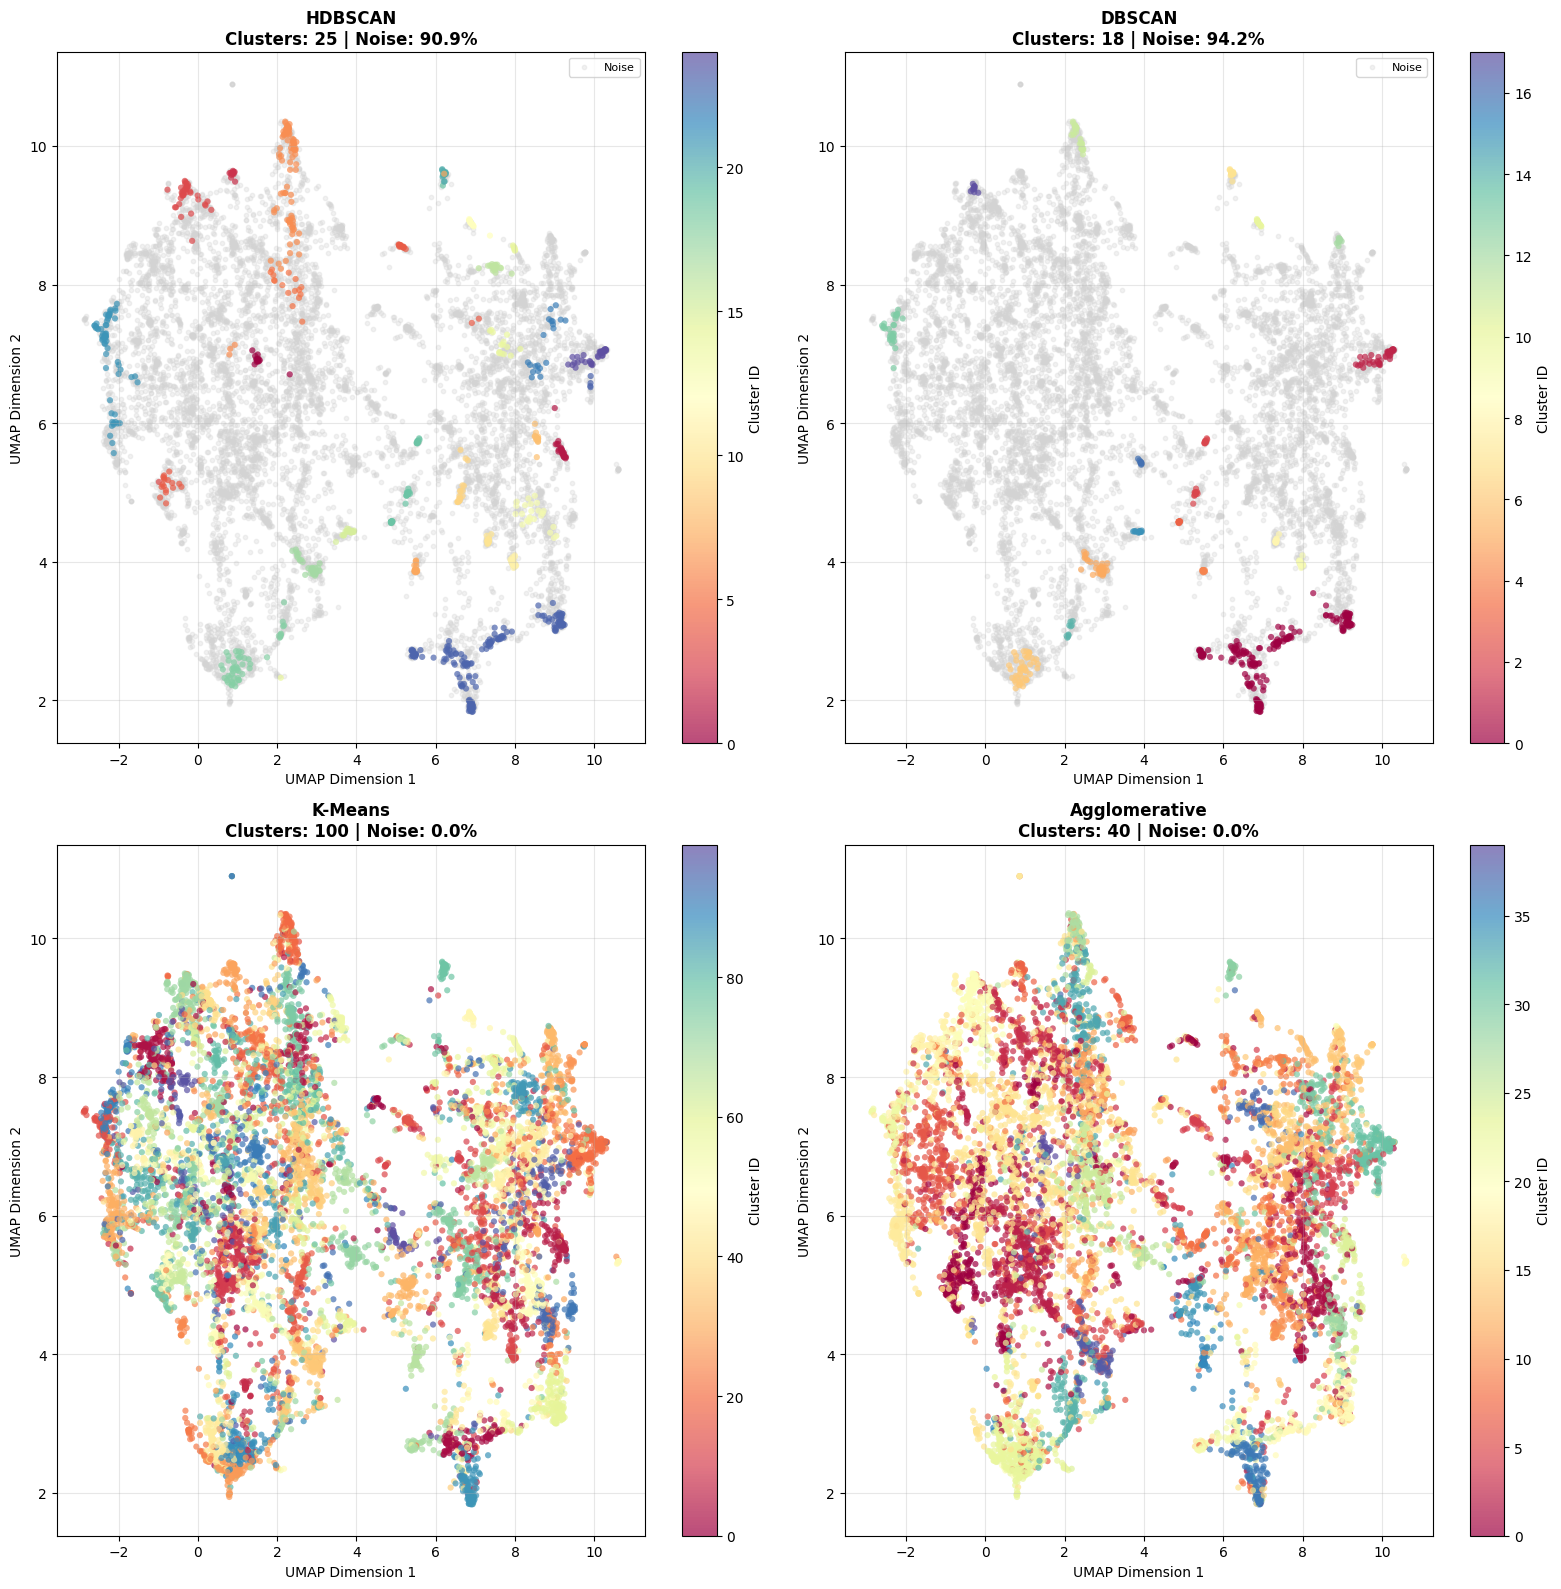


[2/2] Creating individual interactive plots...
   Displaying: HDBSCAN


   Displaying: DBSCAN


   Displaying: K-Means


   Displaying: Agglomerative


In [ ]:
print("\nLoading saved clustering labels...")

method_labels_dict = {}
label_files = {
    'HDBSCAN': './outputlabels/best_hdbscan_labels.npy',
    'DBSCAN': './outputlabels/best_dbscan_labels.npy',
    'K-Means': './outputlabels/best_kmeans_labels.npy',
    'Agglomerative': './outputlabels/best_agglomerative_labels.npy'
}

for method_name, filename in label_files.items():
    try:
        labels = np.load(filename)
        method_labels_dict[method_name] = labels
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        print(f"   {method_name}: {n_clusters} clusters, {n_noise} noise points")
    except FileNotFoundError:
        print(f"  {method_name}: File not found - {filename}")

if not method_labels_dict:
    print("\nERROR: No label files found. Run the clustering script first!")
    exit(1)

print(f"\nLoaded {len(method_labels_dict)} clustering methods")

# ============================================================================
# UMAP VISUALIZATION FUNCTION
# ============================================================================

def visualize_all_methods_umap(X_reduced, method_labels_dict, unique_ingredients=None, 
                                n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Create comprehensive UMAP visualizations for all clustering methods.
    """
    
    print("\n" + "="*80)
    print("CREATING UMAP VISUALIZATIONS")
    print("="*80)
    
    # Compute UMAP embedding once
    print(f"\nComputing UMAP embedding (this may take a few minutes)...")
    print(f"  n_neighbors={n_neighbors}, min_dist={min_dist}")
    
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=random_state,
        verbose=True
    )
    embedding = umap_model.fit_transform(X_reduced)
    print(f" UMAP embedding complete: {embedding.shape}")
    
    # ========================================================================
    # 1. STATIC MATPLOTLIB VISUALIZATION
    # ========================================================================
    print("\n[1/3] Creating static matplotlib grid...")
    
    n_methods = len(method_labels_dict)
    n_cols = 2
    n_rows = (n_methods + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8 * n_rows))
    if n_methods == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (method_name, labels) in enumerate(method_labels_dict.items()):
        ax = axes[idx]
        
        df_method = pd.DataFrame({
            'x': embedding[:, 0],
            'y': embedding[:, 1],
            'cluster': labels
        })
        
        df_noise = df_method[df_method['cluster'] == -1]
        df_clusters = df_method[df_method['cluster'] != -1]
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_pct = (len(df_noise) / len(labels)) * 100
        
        # Plot noise
        if len(df_noise) > 0:
            ax.scatter(df_noise['x'], df_noise['y'], 
                      c='lightgray', s=10, alpha=0.3, label='Noise')
        
        # Plot clusters
        if len(df_clusters) > 0:
            scatter = ax.scatter(df_clusters['x'], df_clusters['y'],
                               c=df_clusters['cluster'], 
                               cmap='Spectral',
                               s=20, alpha=0.7, linewidth=0)
            if n_clusters > 1:
                plt.colorbar(scatter, ax=ax, label='Cluster ID')
        
        ax.set_title(f"{method_name}\nClusters: {n_clusters} | Noise: {noise_pct:.1f}%", 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        if len(df_noise) > 0:
            ax.legend(loc='upper right', fontsize=8)
        ax.grid(alpha=0.3)
    
    for idx in range(n_methods, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('umap_all_methods_static.png', dpi=300, bbox_inches='tight')
    print("   Saved: umap_all_methods_static.png")
    plt.show()
    
    # ========================================================================
    # 2. INTERACTIVE PLOTLY - INDIVIDUAL PLOTS (SHOW ONLY, NO SAVE)
    # ========================================================================
    print("\n[2/2] Creating individual interactive plots...")
    
    for method_name, labels in method_labels_dict.items():
        df_method = pd.DataFrame({
            'x': embedding[:, 0],
            'y': embedding[:, 1],
            'cluster': labels
        })
        
        if unique_ingredients is not None:
            df_method['ingredient'] = unique_ingredients
        
        df_noise = df_method[df_method['cluster'] == -1].copy()
        df_clusters = df_method[df_method['cluster'] != -1].copy()
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_pct = (len(df_noise) / len(labels)) * 100
        
        fig = go.Figure()
        
        # Noise points
        if len(df_noise) > 0:
            hover_data = ['ingredient'] if unique_ingredients else []
            fig.add_trace(go.Scatter(
                x=df_noise['x'],
                y=df_noise['y'],
                mode='markers',
                name='Noise',
                marker=dict(size=4, color='lightgray', opacity=0.4),
                text=df_noise['ingredient'] if unique_ingredients else None,
                hovertemplate='<b>Noise</b><br>%{text}<br>x: %{x:.2f}<br>y: %{y:.2f}<extra></extra>'
            ))
        
        # Cluster points
        if len(df_clusters) > 0:
            fig.add_trace(go.Scatter(
                x=df_clusters['x'],
                y=df_clusters['y'],
                mode='markers',
                name='Clusters',
                marker=dict(
                    size=6,
                    color=df_clusters['cluster'],
                    colorscale='Spectral',
                    opacity=0.8,
                    colorbar=dict(title="Cluster", thickness=15, len=0.7),
                    showscale=True
                ),
                text=df_clusters['ingredient'] if unique_ingredients else None,
                customdata=df_clusters['cluster'],
                hovertemplate='<b>Cluster %{customdata}</b><br>%{text}<br>x: %{x:.2f}<br>y: %{y:.2f}<extra></extra>'
            ))
        
        fig.update_layout(
            title=f"<b>{method_name}</b><br><sub>Clusters: {n_clusters} | Noise: {noise_pct:.1f}%</sub>",
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            width=900, height=700,
            template='plotly_white',
            hovermode='closest'
        )
        
        print(f"   Displaying: {method_name}")
        fig.show()
    
    
    return embedding, umap_model


# ============================================================================
# RUN VISUALIZATION
# ============================================================================

embedding, umap_model = visualize_all_methods_umap(
    X_reduced, 
    method_labels_dict,
    unique_ingredients=unique_ingredients,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)



LOADING CLUSTERING LABELS
 HDBSCAN: 25 clusters, 8970 noise points
 DBSCAN: 18 clusters, 9296 noise points
 K-Means: 100 clusters, 0 noise points
 Agglomerative: 40 clusters, 0 noise points

 Successfully loaded 4 methods

DEEP CLUSTER INTERPRETATION: HDBSCAN

Analyzing 25 clusters (excluding noise)...

CLUSTER 0: 16 ingredients

 Top 10 most frequent ingredients:
  mushroom                                    4,645 recipes
  dove breasts                                    3 recipes
  fat free hollandaise mix                        2 recipes
  fat free vegetable soup                         2 recipes
  lowfat pepperoni                                2 recipes
  tomato sauce with herbs                         2 recipes
  vegit seasoning                                 2 recipes
  boneless duck leg                               1 recipes
  bonito tuna                                     1 recipes
  chicken broth soup                              1 recipes

 Co-occurrence analysis:
  Reci

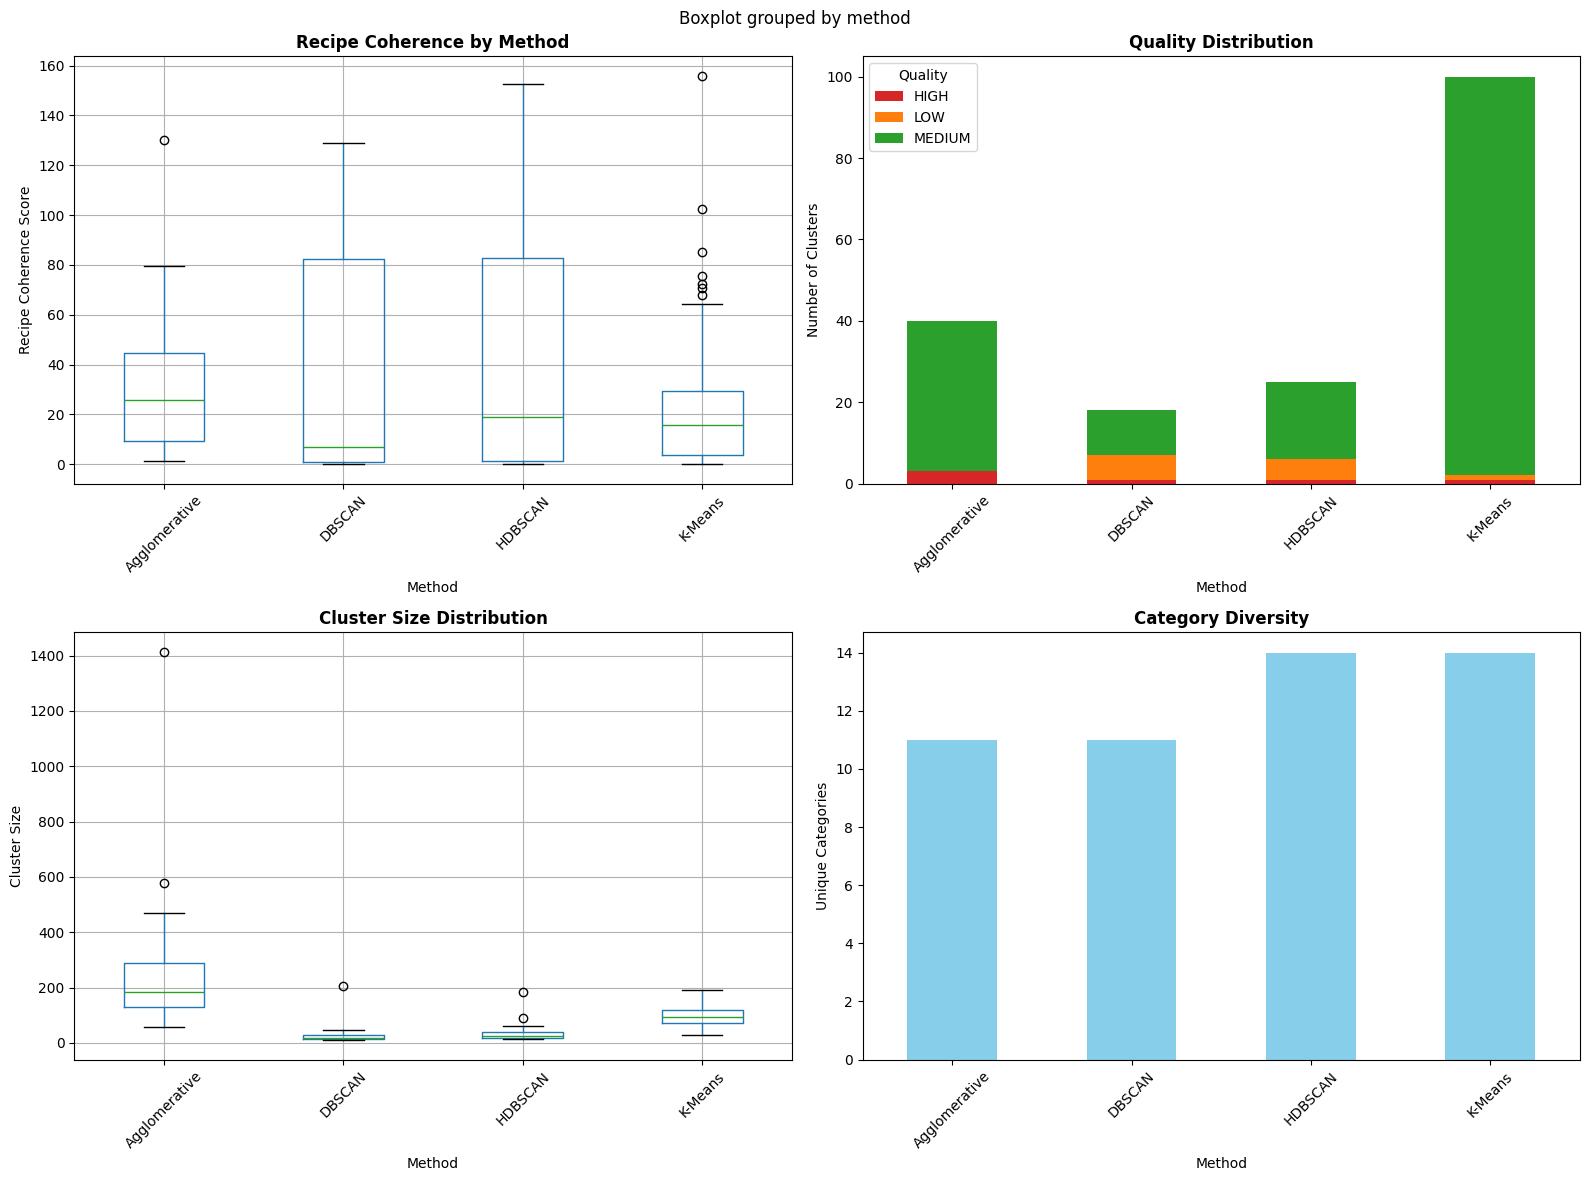

In [11]:

from scipy.sparse import lil_matrix


print("\n" + "="*80)
print("LOADING CLUSTERING LABELS")
print("="*80)

method_labels_dict = {}
label_files = {
    'HDBSCAN': './outputlabels/best_hdbscan_labels.npy',
    'DBSCAN': './outputlabels/best_dbscan_labels.npy',
    'K-Means': './outputlabels/best_kmeans_labels.npy',
    'Agglomerative': './outputlabels/best_agglomerative_labels.npy'
}

for method_name, filename in label_files.items():
    try:
        labels = np.load(filename)
        method_labels_dict[method_name] = labels
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        print(f" {method_name}: {n_clusters} clusters, {n_noise} noise points")
    except FileNotFoundError:
        print(f" {method_name}: File not found - {filename}")

if not method_labels_dict:
    print("\n ERROR: No label files found! Run clustering first.")
    exit(1)

print(f"\n Successfully loaded {len(method_labels_dict)} methods")

# ============================================================================
# DEEP CLUSTER INTERPRETATION FUNCTION
# ============================================================================

def deep_cluster_interpretation(labels, ingredient_names, df_recipes, method_name="Unknown"):
    """
    Comprehensive cluster analysis
    """
    
    print("\n" + "="*80)
    print(f"DEEP CLUSTER INTERPRETATION: {method_name}")
    print("="*80)
    
    # Calculate global ingredient frequencies
    all_ingredients_list = []
    for ing_list in df_recipes['ingredients']:
        all_ingredients_list.extend(ing_list)
    ingredient_freq = pd.Series(all_ingredients_list).value_counts()
    
    cluster_analysis = []
    valid_cluster_ids = sorted([c for c in set(labels) if c != -1])
    
    print(f"\nAnalyzing {len(valid_cluster_ids)} clusters (excluding noise)...")
    
    for cluster_id in valid_cluster_ids:
        cluster_ings = [ing for ing, label in zip(ingredient_names, labels) 
                       if label == cluster_id]
        
        if len(cluster_ings) < 3:
            continue
        
        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster_id}: {len(cluster_ings)} ingredients")
        print(f"{'='*60}")
        
        # 1. FREQUENCY ANALYSIS
        ing_freqs = {ing: ingredient_freq.get(ing, 0) for ing in cluster_ings}
        sorted_ings = sorted(ing_freqs.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\n Top 10 most frequent ingredients:")
        for ing, freq in sorted_ings[:10]:
            print(f"  {ing:<40} {freq:>8,} recipes")
        
        # 2. CO-OCCURRENCE ANALYSIS
        cluster_recipes = []
        cluster_ing_counts = []
        
        for _, recipe in df_recipes.iterrows():
            recipe_ings = set(recipe['ingredients'])
            cluster_ings_in_recipe = [ing for ing in cluster_ings if ing in recipe_ings]
            if len(cluster_ings_in_recipe) >= 2:
                cluster_recipes.append(cluster_ings_in_recipe)
                cluster_ing_counts.append(len(cluster_ings_in_recipe))
        
        avg_co_occurrence = np.mean(cluster_ing_counts) if cluster_ing_counts else 0
        max_co_occurrence = max(cluster_ing_counts) if cluster_ing_counts else 0
        
        print(f"\n Co-occurrence analysis:")
        print(f"  Recipes with ≥2 cluster ingredients: {len(cluster_recipes):,}")
        print(f"  Avg cluster ingredients per recipe: {avg_co_occurrence:.2f}")
        print(f"  Max cluster ingredients in one recipe: {max_co_occurrence}")
        
        # 3. COHERENCE SCORING
        recipe_coherence = len(cluster_recipes) / len(cluster_ings) if len(cluster_ings) > 0 else 0
        density_coherence = avg_co_occurrence if cluster_recipes else 0
        coverage_coherence = (avg_co_occurrence / len(cluster_ings)) * 100 if len(cluster_ings) > 0 else 0
        
        print(f"\n Coherence metrics:")
        print(f"  Recipe coherence: {recipe_coherence:.2f}")
        print(f"  Density coherence: {density_coherence:.2f}")
        print(f"  Coverage coherence: {coverage_coherence:.1f}%")
        
        if recipe_coherence > 10 and density_coherence > 3:
            interpretation = "HIGHLY COHERENT - strong culinary relationship"
            quality = "HIGH"
        elif recipe_coherence > 3 or density_coherence > 2:
            interpretation = "MODERATELY COHERENT - meaningful grouping"
            quality = "MEDIUM"
        else:
            interpretation = "WEAK COHERENCE - potential artifact"
            quality = "LOW"
        
        print(f"  {interpretation}")
        
        # 4. CATEGORY DETECTION
        categories = {
            'baking': ['flour', 'sugar', 'baking', 'cake', 'yeast', 'dough', 'vanilla', 'powder'],
            'dairy': ['milk', 'cheese', 'cream', 'butter', 'yogurt', 'cheddar', 'mozzarella'],
            'protein': ['chicken', 'beef', 'pork', 'bacon', 'sausage', 'turkey', 'lamb', 'ham'],
            'seafood': ['fish', 'shrimp', 'tuna', 'salmon', 'crab', 'lobster', 'clam', 'oyster'],
            'asian': ['soy', 'sesame', 'ginger', 'rice', 'noodle', 'miso', 'teriyaki', 'wasabi'],
            'mexican': ['tortilla', 'salsa', 'cilantro', 'jalapeno', 'beans', 'cumin', 'lime'],
            'italian': ['pasta', 'tomato', 'basil', 'oregano', 'parmesan', 'mozzarella', 'olive'],
            'indian': ['curry', 'turmeric', 'cumin', 'coriander', 'garam', 'masala', 'tikka'],
            'spices': ['cumin', 'coriander', 'turmeric', 'paprika', 'chili', 'pepper', 'cinnamon'],
            'herbs': ['basil', 'parsley', 'cilantro', 'thyme', 'rosemary', 'oregano', 'dill'],
            'vegetables': ['tomato', 'onion', 'garlic', 'carrot', 'pepper', 'spinach', 'broccoli'],
            'fruits': ['apple', 'lemon', 'orange', 'banana', 'berry', 'strawberry', 'grape'],
            'beverages': ['juice', 'coffee', 'tea', 'soda', 'wine', 'beer', 'water'],
            'dessert': ['chocolate', 'vanilla', 'caramel', 'ice cream', 'candy', 'frosting'],
            'condiments': ['sauce', 'vinegar', 'mustard', 'ketchup', 'mayo', 'dressing'],
            'grains': ['rice', 'wheat', 'oat', 'quinoa', 'barley', 'bread', 'cereal']
        }
        
        category_scores = {}
        for cat, keywords in categories.items():
            matches = [ing for ing in cluster_ings 
                      if any(kw in ing.lower() for kw in keywords)]
            score = len(matches) / len(cluster_ings)
            category_scores[cat] = score
        
        top_categories = sorted(category_scores.items(), key=lambda x: x[1], reverse=True)[:3]
        
        print(f"\n Category classification:")
        if top_categories[0][1] > 0.2:
            print(f"  Primary: {top_categories[0][0].upper()} ({top_categories[0][1]*100:.0f}%)")
            if len(top_categories) > 1 and top_categories[1][1] > 0.15:
                print(f"  Secondary: {top_categories[1][0].upper()} ({top_categories[1][1]*100:.0f}%)")
        else:
            print(f"  Category: MIXED/SPECIALIZED")
        
        # Store results
        avg_freq = np.mean(list(ing_freqs.values()))
        median_freq = np.median(list(ing_freqs.values()))
        
        cluster_analysis.append({
            'method': method_name,
            'cluster_id': cluster_id,
            'size': len(cluster_ings),
            'avg_frequency': avg_freq,
            'median_frequency': median_freq,
            'recipe_coherence': recipe_coherence,
            'density_coherence': density_coherence,
            'coverage_coherence': coverage_coherence,
            'quality': quality,
            'interpretation': interpretation,
            'primary_category': top_categories[0][0] if top_categories[0][1] > 0.2 else 'mixed',
            'category_match_pct': top_categories[0][1] * 100,
            'secondary_category': top_categories[1][0] if len(top_categories) > 1 and top_categories[1][1] > 0.15 else '',
            'recipes_with_cluster': len(cluster_recipes),
            'max_co_occurrence': max_co_occurrence,
            'top_5_ingredients': ', '.join([ing for ing, _ in sorted_ings[:5]]),
            'top_10_ingredients': ', '.join([ing for ing, _ in sorted_ings[:10]])
        })
    
    if not cluster_analysis:
        print("\n  No valid clusters found")
        return pd.DataFrame()
    
    analysis_df = pd.DataFrame(cluster_analysis)
    analysis_df = analysis_df.sort_values('recipe_coherence', ascending=False)
    
    print("\n" + "="*80)
    print(f"QUALITY RANKING: {method_name}")
    print("="*80)
    print(analysis_df[['cluster_id', 'size', 'recipe_coherence', 'quality', 
                       'primary_category']].head(10).to_string(index=False))
    
    filename = f"./outputcsv/cluster_interpretation_{method_name.lower().replace('-', '_').replace(' ', '_')}.csv"
    analysis_df.to_csv(filename, index=False)
    print(f"\n Saved: {filename}")
    
    return analysis_df


# ============================================================================
# RUN INTERPRETATION ON ALL METHODS
# ============================================================================

all_interpretations = []

for method_name, labels in method_labels_dict.items():
    interpretation_df = deep_cluster_interpretation(
        labels, 
        unique_ingredients, 
        df, 
        method_name
    )
    
    if not interpretation_df.empty:
        all_interpretations.append(interpretation_df)

# ============================================================================
# COMPARATIVE ANALYSIS
# ============================================================================

if not all_interpretations:
    print("\n  No interpretations generated")
    exit(1)

combined_df = pd.concat(all_interpretations, ignore_index=True)

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: ALL METHODS")
print("="*80)

# Method statistics
method_stats = combined_df.groupby('method').agg({
    'cluster_id': 'count',
    'recipe_coherence': 'mean',
    'density_coherence': 'mean',
    'size': 'mean'
}).round(2)
method_stats.columns = ['num_clusters', 'avg_recipe_coherence', 'avg_density_coherence', 'avg_cluster_size']

print("\n Method comparison:")
print(method_stats.to_string())

# Quality distribution
print("\n Quality distribution by method:")
quality_pivot = pd.crosstab(combined_df['method'], combined_df['quality'], normalize='index') * 100
print(quality_pivot.round(1).to_string())

# Best clusters
print("\n Top 10 clusters (by recipe coherence):")
top_clusters = combined_df.nlargest(10, 'recipe_coherence')[
    ['method', 'cluster_id', 'size', 'recipe_coherence', 'primary_category', 'top_5_ingredients']
]
print(top_clusters.to_string(index=False))

# Save combined
combined_df.to_csv('./outputcsv/cluster_interpretation_all_methods.csv', index=False)
print(f"\n Combined results: cluster_interpretation_all_methods.csv")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recipe coherence
combined_df.boxplot(column='recipe_coherence', by='method', ax=axes[0, 0])
axes[0, 0].set_title('Recipe Coherence by Method', fontweight='bold')
axes[0, 0].set_xlabel('Method')
axes[0, 0].set_ylabel('Recipe Coherence Score')
plt.sca(axes[0, 0])
plt.xticks(rotation=45)

# 2. Quality distribution
quality_counts = combined_df.groupby(['method', 'quality']).size().unstack(fill_value=0)
quality_counts.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                   color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_title('Quality Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Method')
axes[0, 1].set_ylabel('Number of Clusters')
axes[0, 1].legend(title='Quality')
plt.sca(axes[0, 1])
plt.xticks(rotation=45)

# 3. Cluster size
combined_df.boxplot(column='size', by='method', ax=axes[1, 0])
axes[1, 0].set_title('Cluster Size Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Method')
axes[1, 0].set_ylabel('Cluster Size')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# 4. Category diversity
category_counts = combined_df.groupby('method')['primary_category'].nunique()
category_counts.plot(kind='bar', ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Category Diversity', fontweight='bold')
axes[1, 1].set_xlabel('Method')
axes[1, 1].set_ylabel('Unique Categories')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('cluster_interpretation_comparison.png', dpi=300, bbox_inches='tight')
print(" Saved: cluster_interpretation_comparison.png")
plt.show()
